# 2.2 Visualizations

In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

## 0

In [31]:
cardio_raw = pd.read_csv("./data/cardio_train.csv", sep=";", dtype={'gluc':'category', 'cholesterol':'category', 'gender':'category', 'smoke':'category', 'alco': 'category', 'active': 'category'}).drop(columns=['id'])

cardio_raw.head(1)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,18393,2,168,62.0,110,80,1,1,0,0,1,0


In [32]:
height_in_m = cardio_raw.query('height > 147 & height < 250')['height'].apply(lambda height: height * 0.01)

height_weight_cleaned = cardio_raw.drop(columns=['height']).join(height_in_m).dropna()

bmi_raw = cardio_raw.join(height_weight_cleaned.apply(lambda row: 1.3 * row.weight / pow(row.height, 2.5), axis=1).rename('BMI')).dropna()

bmi_cleaned = bmi_raw.drop(bmi_raw.query('BMI < 16 | BMI > 60').index).drop(columns=['height','weight'])
cardio_raw_with_bmi = bmi_cleaned.join(pd.cut(
    bmi_cleaned["BMI"],
    [0, 16.9, 18.4, 24.9, 29.9, 34.9, 39.9, 100],
    labels=[
        "Moderate thinness",
        "Mild thinness",
        "Normal range",
        "Pre-obese",
        "Class I",
        "Class II",
        "Class III",
    ],
).rename('BMI Category'))
cardio_raw_with_bmi.head(1)

,age,gender,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI,BMI Category
0,18393,2,110,80,1,1,0,0,1,0,22.032402,Normal range


In [33]:
blood_pressure_cleaned = cardio_raw_with_bmi.drop(
    pd.concat(
        [
            cardio_raw_with_bmi.query("ap_lo < 50"),
            cardio_raw_with_bmi.query("ap_lo > 200"),
            cardio_raw_with_bmi.query("ap_hi < 60"),
            cardio_raw_with_bmi.query("ap_hi > 240"),
        ]
    ).index
)
def blood_pressure_category(row):
    if (row['ap_hi'] < 120) and (row['ap_lo'] < 80):
        return 'Healthy'
    if (row['ap_hi'] <= 129) and (row['ap_lo'] < 80):
        return 'Elevated'
    if (row['ap_hi'] <= 139) or (row['ap_lo'] <= 89):
        return 'Stage 1 hypertension'
    if (row['ap_lo'] <= 179) or (row['ap_lo'] <= 119):
        return 'Stage 2 hypertension'
    if (row['ap_hi'] >= 180) or (row['ap_lo'] >= 120):
        return 'Hypertension crisis'

cardio_cleaned_with_new_categories = blood_pressure_cleaned.join(pd.DataFrame(blood_pressure_cleaned.apply(blood_pressure_category, axis=1).rename('Blood Pressure Category')))

cardio_cleaned_with_new_categories.head(1)

,age,gender,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI,BMI Category,Blood Pressure Category
0,18393,2,110,80,1,1,0,0,1,0,22.032402,Normal range,Stage 1 hypertension


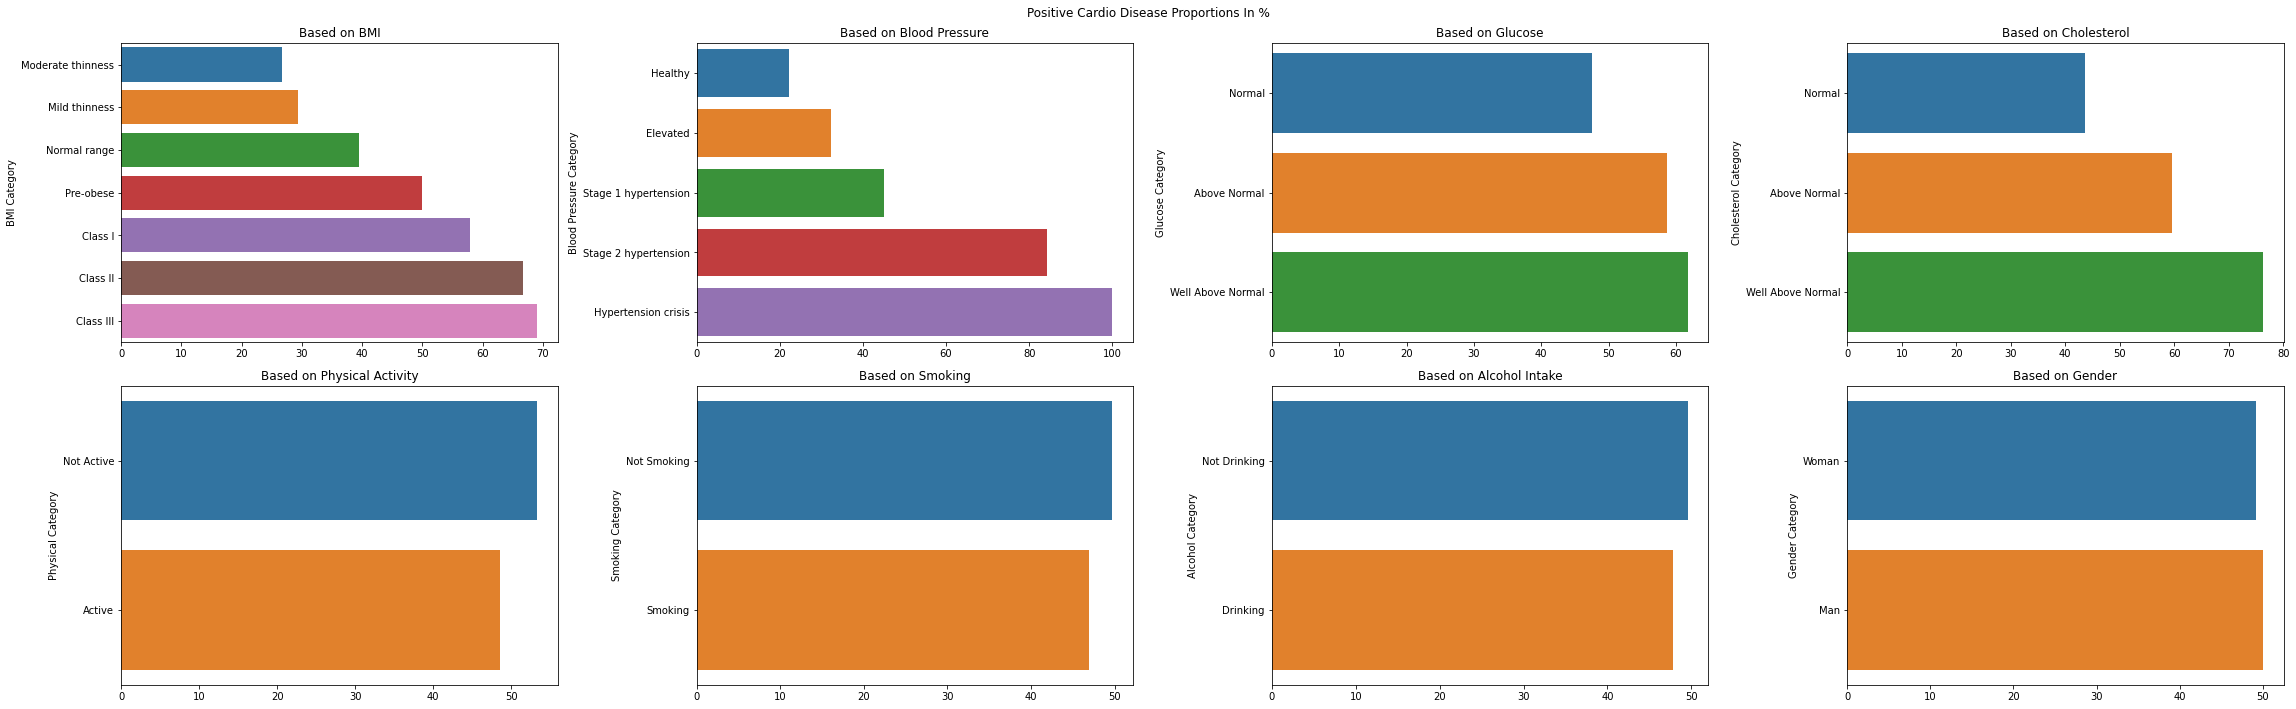

In [34]:
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, figsize=(32, 10))

plt.suptitle("Positive Cardio Disease Proportions In %")

sns.barplot(
    data=cardio_cleaned_with_new_categories,
    ax=ax1,
    y="BMI Category",
    x="cardio",
    ci=None,
    order=[
        "Moderate thinness",
        "Mild thinness",
        "Normal range",
        "Pre-obese",
        "Class I",
        "Class II",
        "Class III",
    ],
).set_title("Based on BMI")

sns.barplot(
    ax=ax2,
    data=cardio_cleaned_with_new_categories,
    y="Blood Pressure Category",
    x="cardio",
    ci=None,
    order=[
        "Healthy",
        "Elevated",
        "Stage 1 hypertension",
        "Stage 2 hypertension",
        "Hypertension crisis",
    ],
).set_title("Based on Blood Pressure")

sns.barplot(
    ax=ax3,
    data=cardio_cleaned_with_new_categories,
    y="gluc",
    x="cardio",
    ci=None
).set_title("Based on Blood Pressure")
ax3.set(
    ylabel="Glucose Category",
    yticklabels=["Normal", "Above Normal", "Well Above Normal"],
)

sns.barplot(
    ax=ax3,
    data=cardio_cleaned_with_new_categories,
    y="gluc",
    x="cardio",
    ci=None
).set_title("Based on Glucose")
ax3.set(
    ylabel="Glucose Category",
    yticklabels=["Normal", "Above Normal", "Well Above Normal"],
)

sns.barplot(
    ax=ax4,
    data=cardio_cleaned_with_new_categories,
    y="cholesterol",
    x="cardio",
    ci=None
).set_title("Based on Cholesterol")
ax4.set(
    ylabel="Cholesterol Category",
    yticklabels=["Normal", "Above Normal", "Well Above Normal"],
)

sns.barplot(
    ax=ax5,
    data=cardio_cleaned_with_new_categories,
    y="active",
    x="cardio",
    ci=None
).set_title("Based on Physical Activity")
ax5.set(ylabel="Physical Category", yticklabels=["Not Active", "Active"])

sns.barplot(
    ax=ax6,
    data=cardio_cleaned_with_new_categories,
    y="smoke",
    x="cardio",
    ci=None
).set_title("Based on Smoking")
ax6.set(ylabel="Smoking Category", yticklabels=["Not Smoking", "Smoking"])

sns.barplot(
    ax=ax7,
    data=cardio_cleaned_with_new_categories,
    y="alco",
    x="cardio",
    ci=None
).set_title("Based on Alcohol Intake")
ax7.set(ylabel="Alcohol Category", yticklabels=["Not Drinking", "Drinking"])

sns.barplot(
    ax=ax8,
    data=cardio_cleaned_with_new_categories,
    y="gender",
    x="cardio",
    ci=None
).set_title("Based on Gender")
ax8.set(ylabel="Gender Category", yticklabels=["Woman", "Man"])

for ax in (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8):
    ax.get_xaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x * 100), ","))
    )
    ax.set(xlabel="")
plt.tight_layout()

## 1

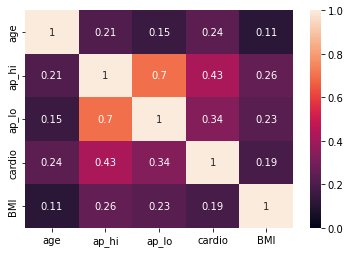

In [35]:
sns.heatmap(cardio_cleaned_with_new_categories.corr(), vmin=0, annot=True);

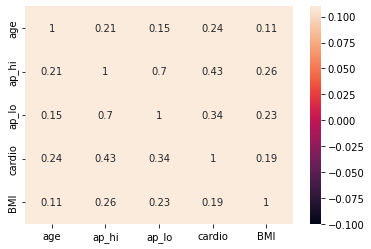

In [36]:
sns.heatmap(cardio_cleaned_with_new_categories.corr(), vmax=0, annot=True);

In [43]:
cardio_raw_without_categories = pd.read_csv("./data/cardio_train.csv", sep=";").drop(columns=['id', 'age', 'ap_hi', 'ap_lo'])

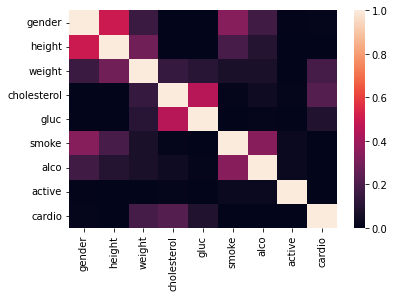

In [47]:
sns.heatmap(cardio_raw_without_categories.corr(), vmin=0);

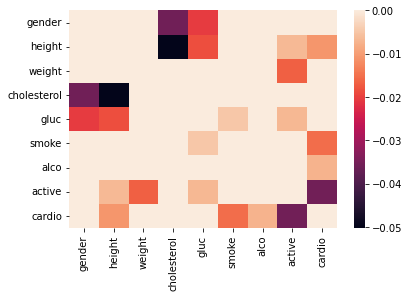

In [46]:
sns.heatmap(cardio_raw_without_categories.corr(), vmax=0);

In [40]:
pd.DataFrame(cardio_cleaned_with_new_categories["age"].apply(lambda age_in_days: round(age_in_days / 365, 0)).describe()).T.drop(columns=['count'])

,mean,std,min,25%,50%,75%,max
age,53.302988,6.765136,30.0,48.0,54.0,58.0,65.0


In [41]:
cardio_cleaned_with_new_categories_and_age = cardio_cleaned_with_new_categories.drop(columns=['age']).join(cardio_cleaned_with_new_categories["age"].apply(lambda age_in_days: round(age_in_days / 365, 0)).astype('category'))

C:\Users\CreativeZone2\.virtualenvs\machine-learning-_KPFOz0i\lib\site-packages\seaborn\categorical.py:253: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  grouped_vals = vals.groupby(grouper)


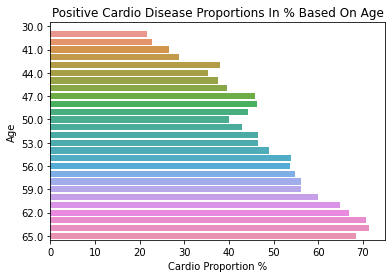

In [42]:
ax = sns.barplot(
    data=cardio_cleaned_with_new_categories_and_age, y="age", x="cardio", ci=None
)
ax.set_title("Positive Cardio Disease Proportions In % Based On Age")
ax.set(ylabel="Age", xlabel="Cardio Proportion %")
ax.set_yticks(range(0, 30, 3))
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x * 100), ","))
)